In [2]:
#import necessary packages
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

In [3]:
import urllib.request, urllib.parse
from urllib.error import HTTPError,URLError

def get_countries_data():
    """
    Function to get information like population from all countries
    """
    url = 'https://restcountries.eu/rest/v2/all'
    try:
        uh = urllib.request.urlopen(url)
    except HTTPError as e:
        print("Sorry! Could not retrive anything")
        return None
    except URLError as e:
        print('Failed to reach a server.')
        print('Reason: ', e.reason)
        return None
    else:
        data = uh.read().decode()
        return json.loads(data)

In [4]:
def request_worldometer_table():
    """
    Function to send request to get worldometer coronavirus table page
    """
    url = 'https://www.worldometers.info/coronavirus/'
    try:
        response = requests.get(url)
    except requests.exceptions.ConnectionError as e:
        print('Error Connecting:', e.args)
        return None
    except requests.exceptions.RequestException as e:
        print('Error Connecting:', e.args)
        return None
    else:
        soup = BeautifulSoup(response.text, 'lxml')
        table = soup.find_all('table')
        
        dataframe = pd.read_html(str(table))[0]
        columns = ['Country', 'Total Cases', 'Drop1', 'Total Deaths', 'Drop2', 'Total Recovered', 'Active Cases', 'Serious / Critical Cases', 'Drop3', 'Drop4', 'Total Tests', 'Drop5']
        dataframe.columns = columns
        dataframe.drop(['Drop1', 'Drop2', 'Drop3', 'Drop4', 'Drop5'], axis=1, inplace=True)
        dataframe.drop([0, len(dataframe.index) -1 ], inplace=True)#Remove the first and last rows from thetable
        return json.loads(dataframe.to_json(orient="records"))

In [5]:
population_json = get_countries_data()
worldometer_json = request_worldometer_table()

In [6]:
def process_population_json():
    return [{'name': country['name'] ,'alt': country['altSpellings'] , 'native name': country['nativeName'], 'population': country['population']} for country in population_json]


In [7]:
def add_population_field_to_worldometer():
    countries = process_population_json()
    for each_dict in worldometer_json:#First iteration that compares the country name in the worldometer table to the country name gotten from restcountries.eu api
        for country in countries:
            if (each_dict['Country'] == country['name']) or (each_dict['Country'] == country['native name']):
                each_dict['population'] = country['population']
                countries.remove(country)#remove the country from the list to make it smaller

    for each_dict in worldometer_json:
        if 'population' not in each_dict:
            for country in countries:
                if(fuzz.partial_ratio(each_dict['Country'], country['name']) == 100):
                    each_dict['population'] = country['population']
                    countries.remove(country)

    for each_dict in worldometer_json:
        if 'population' not in each_dict:
            for country in countries:
                if each_dict['Country'] in country['alt']:
                    each_dict['population'] = country['population']
                    countries.remove(country)

    mapping = {'S. Korea' : 'Korea (Republic of)', 
               'Czechia': 'Czech Republic', 
               'Vietnam' : 'Viet Nam', 
               'North Macedonia': 'Macedonia (the former Yugoslav Republic of)'}

    for each_dict in worldometer_json:
        if ('population' not in each_dict) and (each_dict['Country'] in mapping):
            for country in countries: 
                if (country['name'] == mapping[each_dict['Country']]):
                    each_dict['population'] = country['population']
                    countries.remove(country)
                    
    return worldometer_json

In [8]:
def get_detailed_table():
    worldometer_plus_population = add_population_field_to_worldometer()
    corona_virus_detailed_table = pd.DataFrame(worldometer_plus_population)
    corona_virus_detailed_table.sort_values(by='Total Cases', ascending=False, inplace=True)
    corona_virus_detailed_table.index = range(1, len(corona_virus_detailed_table) + 1)
    return corona_virus_detailed_table

get_detailed_table().head()

,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Serious / Critical Cases,Total Tests,population
1,USA,1212955,69925.0,188068.0,954962,16050.0,7462597.0,323947000.0
2,Spain,248301,25428.0,151633.0,71240,2254.0,1932455.0,46438422.0
3,Italy,211938,29079.0,82879.0,99980,1479.0,2191403.0,60665551.0
4,UK,190584,28734.0,NaN,161506,1559.0,1291591.0,65110000.0
5,France,169462,25201.0,51371.0,92890,3696.0,1100228.0,66710000.0


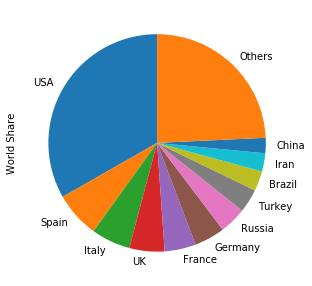

In [9]:
def get_share():
    columns = ['Country', 'Total Cases']
    corona_virus_detailed_table = get_detailed_table()
    countries_world_share = pd.DataFrame(corona_virus_detailed_table, columns = columns)
    countries_world_share['World Share'] = countries_world_share['Total Cases'] / sum(countries_world_share['Total Cases']) * 100
    more_than_2 = countries_world_share[countries_world_share['World Share'] >= 2]
    less_than_2 = countries_world_share[countries_world_share['World Share'] < 2]
    others = pd.DataFrame({'Country' : 'Others', 'Total Cases' : less_than_2['Total Cases'].sum(), 
                           'World Share': less_than_2['World Share'].sum()}, index=[len(more_than_2) + 1])

    world_share_aggregate = pd.concat([more_than_2, others], axis=0)
    return world_share_aggregate.set_index('Country')

get_share().plot.pie(y='World Share', figsize=(5,5), startangle=90, legend=False)

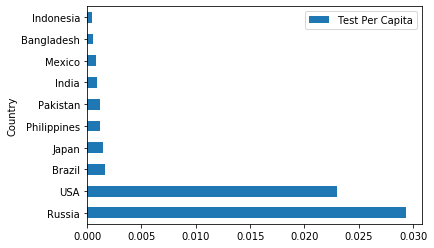

In [12]:
def get_tests_per_capita_table(start=0, stop=10, population_floor=0):
    corona_virus_detailed_table = get_detailed_table()
    tests_per_capita_table = pd.DataFrame(corona_virus_detailed_table, columns=['Country','Total Tests', 'population'])
    tests_per_capita_table['Test Per Capita'] = tests_per_capita_table['Total Tests']/tests_per_capita_table['population']
    tests_per_capita_table.sort_values(by='Test Per Capita', ascending=False, inplace=True)
    tests_per_capita_table.index = range(1, len(tests_per_capita_table) + 1)
    if population_floor == 0:
        return tests_per_capita_table[start : stop]
    elif population_floor == 10000000:
        tpct_over_ten_million = tests_per_capita_table[tests_per_capita_table['population'] >= 10000000]
        tpct_over_ten_million.index = range(1, len(tpct_over_ten_million) + 1)
        return tpct_over_ten_million[start : stop]
    elif population_floor == 100000000:
        tpct_over_hundred_million = tests_per_capita_table[tests_per_capita_table['population'] >= 100000000]
        tpct_over_hundred_million.index = range(1, len(tpct_over_hundred_million) + 1)
        return tpct_over_hundred_million[start : stop]

get_tests_per_capita_table(0, 10, 100000000).plot.barh(x='Country', y='Test Per Capita')

In [13]:
def get_death_rate(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    death_rate = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Total Deaths'])
    death_rate['Death Rate'] = (death_rate['Total Deaths'] / death_rate['Total Cases']) * 100
    death_rate.sort_values(by='Death Rate', ascending=False, inplace=True)
    death_rate = death_rate[death_rate['Total Cases'] >= 1000]
    death_rate.index = range(1, len(death_rate) + 1)
    return death_rate[start:stop]

get_death_rate()

,Country,Total Cases,Total Deaths,Death Rate
1,Belgium,50267,7924.0,15.763821
2,UK,190584,28734.0,15.076817
3,France,169462,25201.0,14.871181
4,Italy,211938,29079.0,13.720522
5,Netherlands,40770,5082.0,12.465048
6,Sweden,22721,2769.0,12.186964
7,Hungary,3065,363.0,11.843393
8,Spain,248301,25428.0,10.240796
9,Algeria,4648,465.0,10.004303
10,Mexico,24905,2271.0,9.118651


In [14]:
def get_recovered(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    percentage_recovered = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Total Recovered'])
    percentage_recovered['Percentage Recovered'] = (percentage_recovered['Total Recovered']/percentage_recovered['Total Cases']) * 100
    percentage_recovered.sort_values(by='Percentage Recovered', ascending=False, inplace=True)
    percentage_recovered.index = range(1, len(percentage_recovered) + 1)
    return percentage_recovered[start:stop]

get_recovered()

,Country,Total Cases,Total Recovered,Percentage Recovered
1,Anguilla,3,3.0,100.000000
2,Papua New Guinea,8,8.0,100.000000
3,Greenland,11,11.0,100.000000
4,Falkland Islands,13,13.0,100.000000
5,St. Barth,6,6.0,100.000000
6,Faeroe Islands,187,185.0,98.930481
7,Cambodia,122,120.0,98.360656
8,Iceland,1799,1723.0,95.775431
9,Mauritius,332,316.0,95.180723
10,New Caledonia,18,17.0,94.444444


In [17]:
def get_active_critical_table(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    active_table = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Active Cases', 'Serious / Critical Cases'])
    active_table['% Active(of Total Cases)'] = (active_table['Active Cases']/active_table['Total Cases']) * 100
    active_table['% Critical(of active)'] = (active_table['Serious / Critical Cases']/active_table['Active Cases']) * 100
    return active_table[start:stop]
    
get_active_critical_table()

,Country,Total Cases,Active Cases,Serious / Critical Cases,% Active(of Total Cases),% Critical(of active)
1,USA,1212955,954962,16050.0,78.730208,1.680695
2,Spain,248301,71240,2254.0,28.690984,3.163953
3,Italy,211938,99980,1479.0,47.174174,1.479296
4,UK,190584,161506,1559.0,84.742686,0.965289
5,France,169462,92890,3696.0,54.814649,3.978900
6,Germany,166152,24059,1949.0,14.480115,8.100919
7,Russia,145268,125817,2300.0,86.610265,1.828052
8,Turkey,127659,56032,1384.0,43.891931,2.470017
9,Brazil,108620,55438,8318.0,51.038483,15.004149
10,Iran,98647,12991,2676.0,13.169179,20.598876


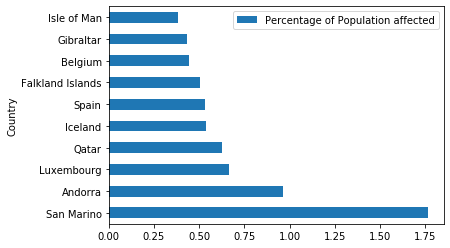

In [18]:
def get_percentage_affected(start=0, stop=10):
    corona_virus_detailed_table = get_detailed_table()
    country_percentage_affected = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'population'])
    country_percentage_affected['Percentage of Population affected'] = (country_percentage_affected['Total Cases'] / country_percentage_affected['population'])*100
    country_percentage_affected.sort_values(by='Percentage of Population affected', ascending=False, inplace=True)
    country_percentage_affected.index = range(1, len(country_percentage_affected) + 1)
    return country_percentage_affected[start:stop]

get_percentage_affected().plot.barh(x='Country', y='Percentage of Population affected')

In [93]:
# corona_virus_detailed_table[corona_virus_detailed_table['population'].isna() ]
# corona_virus_detailed_table[corona_virus_detailed_table['Country'].isin([ 'S. Korea', 'Czechia', 'Vietnam', 'North Macedonia'])  ]